### <b>Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ET1JOEzWfFNInA923UV7Qm8BDxYKaEPTCJXzoHZ1dhjBOA?download=1 -O corrected_facial_identity_latent_vectors.zip
!unzip corrected_facial_identity_latent_vectors.zip -d ./corrected_facial_identity_latent_vectors

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset

EXTENSIONS = [
    '.npy',
]


def is_numpy_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_numpy_file(fname):
                    path = os.path.join(root, fname).split('.npy')[0]
                    item = (path + '.png', path + '.npy', class_to_idx[target])
                    images.append(item)

    return images


def numpy_loader(path):
    return np.load(path)


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class LatentFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.numpy_loader = numpy_loader
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, npy, target = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        npy = self.numpy_loader(npy)
        return img, npy, target

    def __len__(self):
        return len(self.imgs)

In [4]:
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_dir = './corrected_facial_identity_latent_vectors/corrected_facial_identity_latent_vectors'

test_dataset = LatentFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 191
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', '

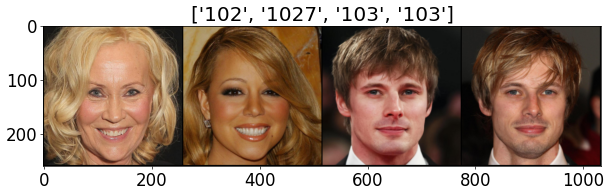

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(test_dataloader)

# visualize a batch of train image
inputs, npys, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Load Pre-trained Model</b>

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1 -O facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth

--2021-03-14 14:59:27--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZUlseHRadFFJZEZoUkNVa0NCU2FJUUJCYlA1ZHVqVFVwUk50ajhUUmluUmFRP3J0aW1lPTAxODd4UG5tMkVn [following]
--2021-03-14 14:59:28--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?

In [7]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [9]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    model
).to(device).eval()

### <b>Test Phase</b>

[Prediction Result Examples]


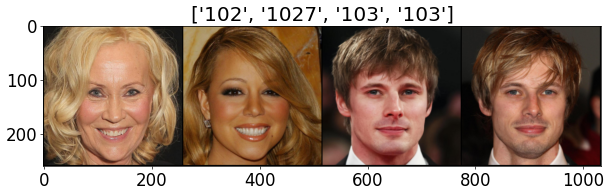

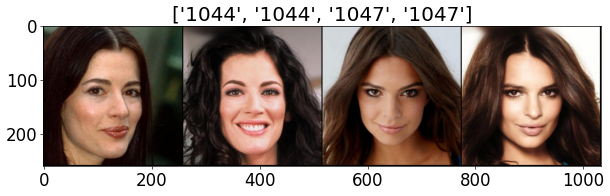

[Test] Loss: 0.0236 Acc: 100.0000% Time: 1.4935s


In [10]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>Prepare Adversarial Attack Libraries</b>

In [13]:
!pip install foolbox
!pip install advertorch

In [14]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 100 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

In [15]:
import random

random.seed(0)
np.random.seed(0)

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


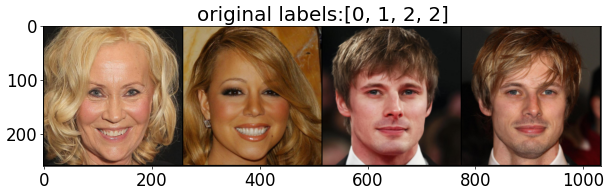

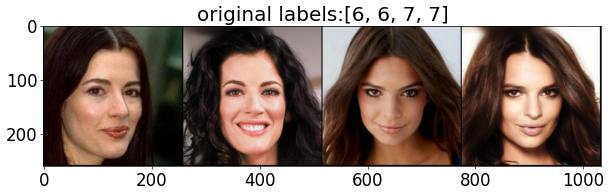

[Start Image Examples]


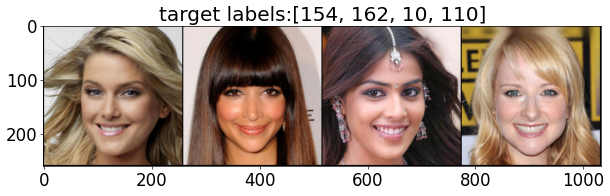

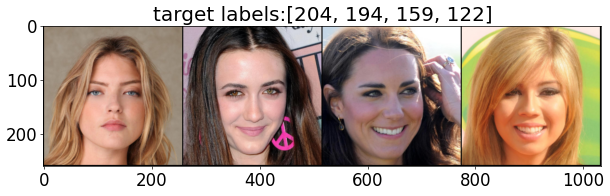

[Attack Result Examples]


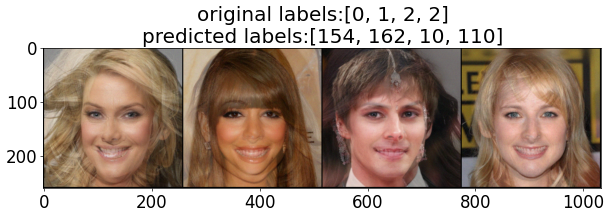

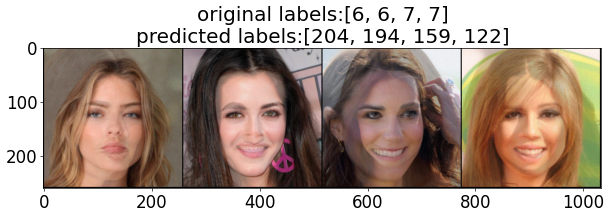

[Step #0] Loss: 0.8622 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3.1317s (total 8 images)
[Step #10] Loss: 0.7775 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 16.8920s (total 88 images)
[Step #20] Loss: 0.7053 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 30.8888s (total 168 images)
[Validation] Loss: 0.6988 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 34.9545s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196596.6335078534
Average L2 distance: 86.85323825057264
Average MSE: 0.041791093911175956
Average Linf distance (the maximum changed values): 0.5499117449316054


In [16]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=100,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 500 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


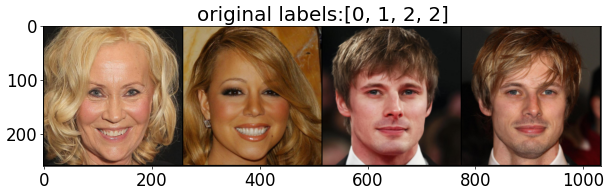

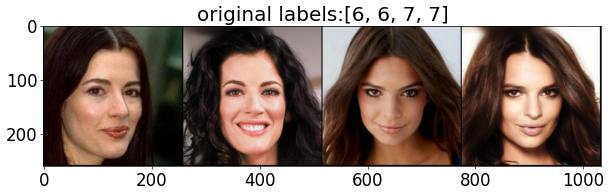

[Start Image Examples]


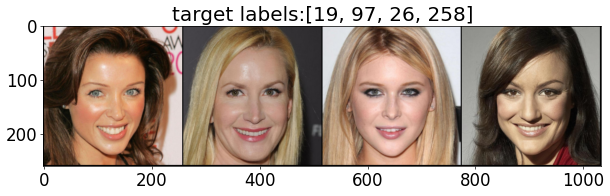

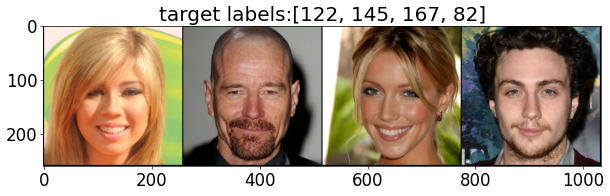

[Attack Result Examples]


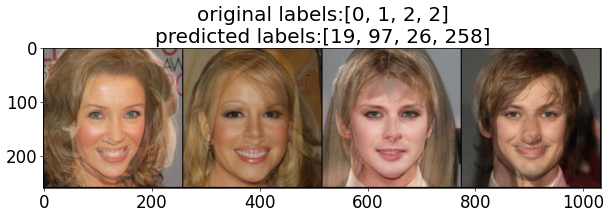

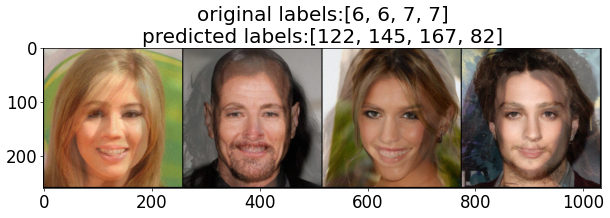

[Step #0] Loss: 0.6177 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 8.3176s (total 8 images)
[Step #10] Loss: 0.6166 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 77.7050s (total 88 images)
[Step #20] Loss: 0.6112 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 146.7462s (total 168 images)
[Validation] Loss: 0.6178 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 166.5541s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196586.4607329843
Average L2 distance: 83.47318495505768
Average MSE: 0.03847041499864368
Average Linf distance (the maximum changed values): 0.5226869882713437


In [17]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=500,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 1000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


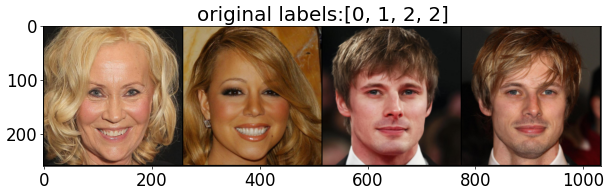

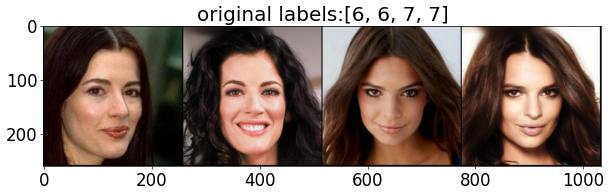

[Start Image Examples]


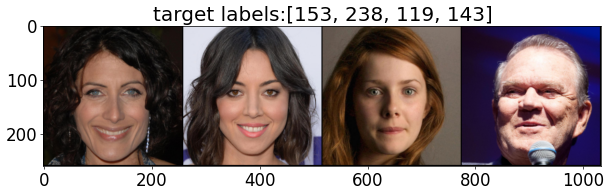

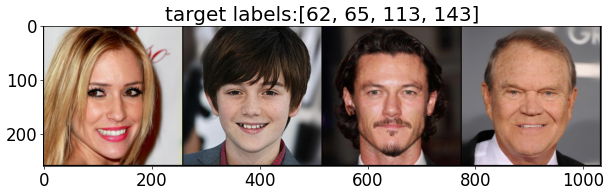

[Attack Result Examples]


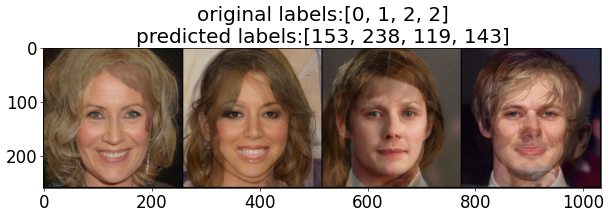

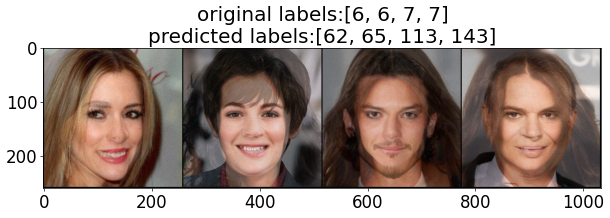

[Step #0] Loss: 0.4547 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 15.2214s (total 8 images)
[Step #10] Loss: 0.5200 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 152.5035s (total 88 images)
[Step #20] Loss: 0.5448 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 289.7674s (total 168 images)
[Validation] Loss: 0.5308 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 329.1511s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196590.49214659687
Average L2 distance: 79.90567288223986
Average MSE: 0.034985236160418126
Average Linf distance (the maximum changed values): 0.5070495830156416


In [18]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=1000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 3000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


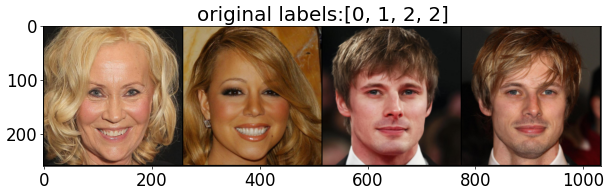

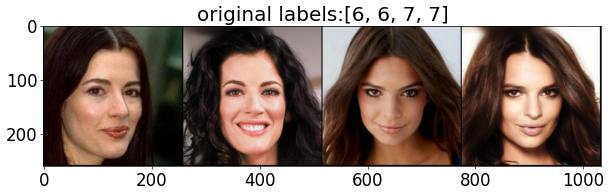

[Start Image Examples]


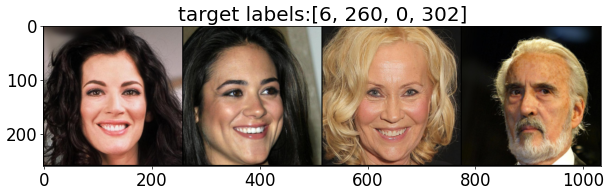

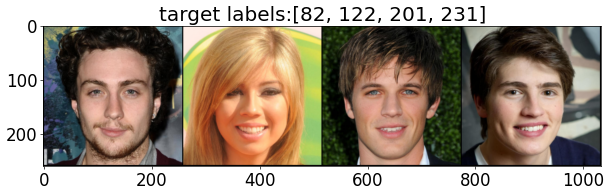

[Attack Result Examples]


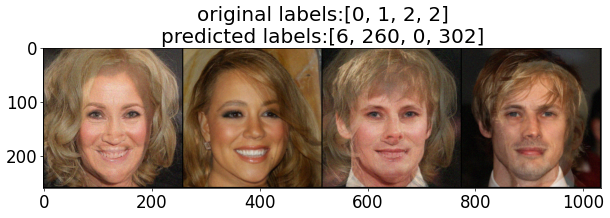

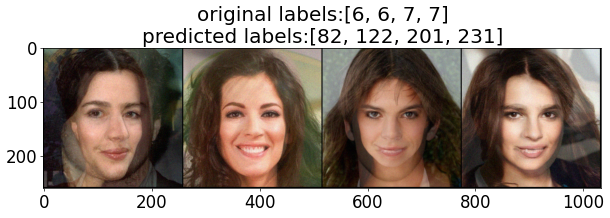

[Step #0] Loss: 0.3791 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 42.7932s (total 8 images)
[Step #10] Loss: 0.2967 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 453.4232s (total 88 images)
[Step #20] Loss: 0.3219 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 864.2824s (total 168 images)
[Validation] Loss: 0.3167 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 982.3592s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196596.45026178012
Average L2 distance: 50.60637325266893
Average MSE: 0.014514321432063717
Average Linf distance (the maximum changed values): 0.36019421247911704


In [19]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=3000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 5000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


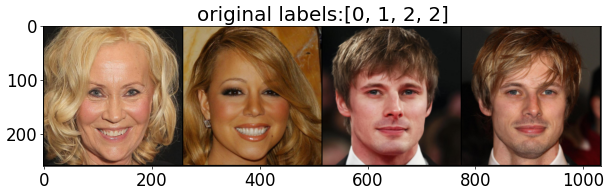

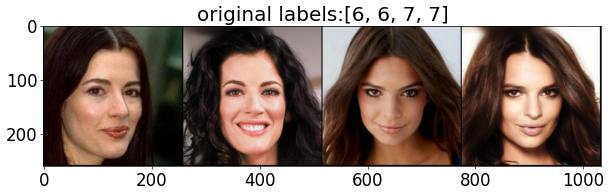

[Start Image Examples]


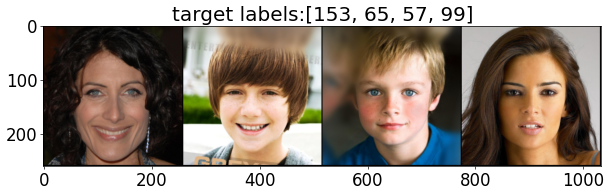

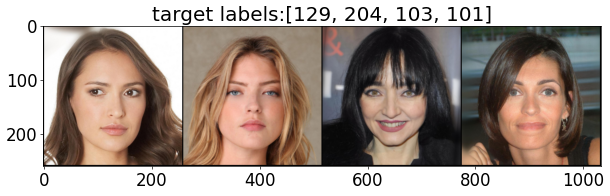

[Attack Result Examples]


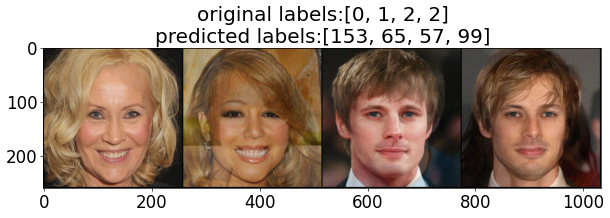

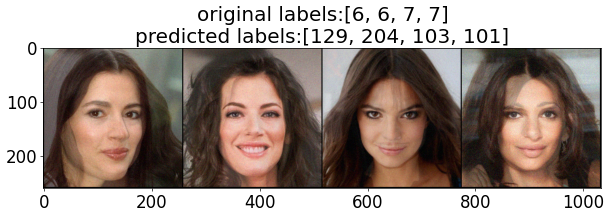

[Step #0] Loss: 0.3397 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 69.9298s (total 8 images)
[Step #10] Loss: 0.2861 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 754.2017s (total 88 images)
[Step #20] Loss: 0.3059 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1438.4018s (total 168 images)
[Validation] Loss: 0.3000 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1634.8629s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196590.70680628272
Average L2 distance: 37.91124234024767
Average MSE: 0.008484922993089516
Average Linf distance (the maximum changed values): 0.28639001184733126


In [20]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=5000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 10000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


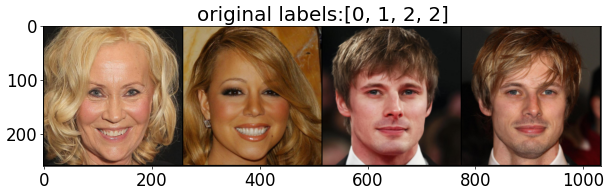

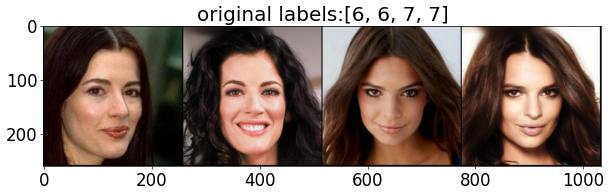

[Start Image Examples]


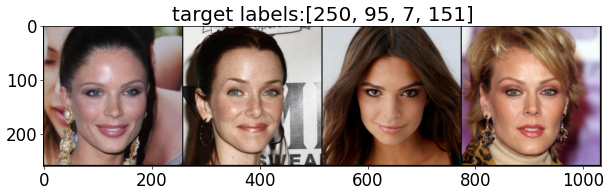

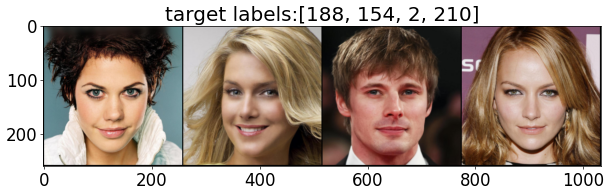

[Attack Result Examples]


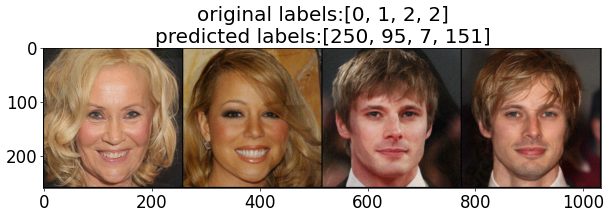

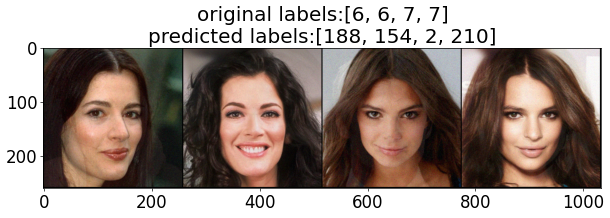

[Step #0] Loss: 0.2465 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 138.4243s (total 8 images)
[Step #10] Loss: 0.2424 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1507.0482s (total 88 images)
[Step #20] Loss: 0.2581 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2875.9010s (total 168 images)
[Validation] Loss: 0.2572 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3268.5818s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196588.05759162304
Average L2 distance: 21.851040705336327
Average MSE: 0.002966746848798235
Average Linf distance (the maximum changed values): 0.1808626633039944


In [21]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=10000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 7</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 20000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


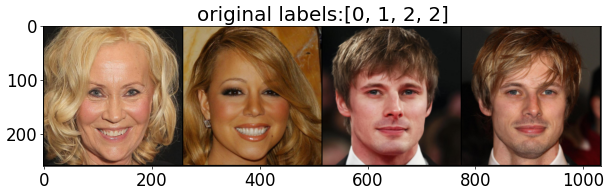

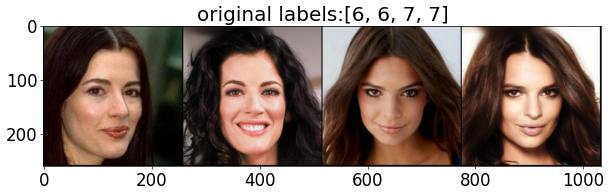

[Start Image Examples]


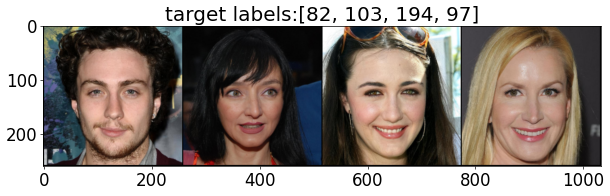

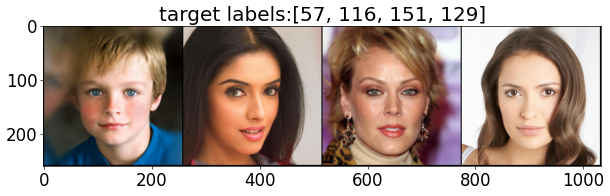

[Attack Result Examples]


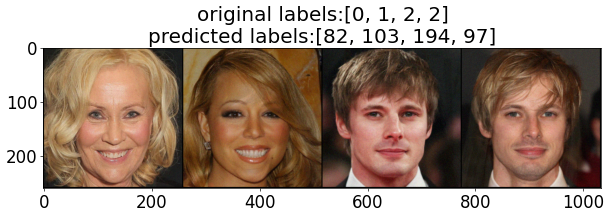

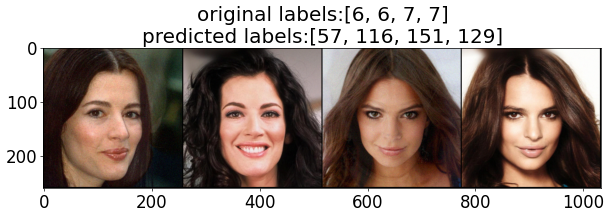

[Step #0] Loss: 0.2709 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 275.2263s (total 8 images)
[Step #10] Loss: 0.2559 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3013.1217s (total 88 images)
[Step #20] Loss: 0.2556 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 5752.8397s (total 168 images)
[Validation] Loss: 0.2573 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 6538.6965s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196584.74869109946
Average L2 distance: 11.12763673472779
Average MSE: 0.000836990248285117
Average Linf distance (the maximum changed values): 0.10246579622098913


In [22]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=20000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], _, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)